In [5]:
! git clone --recursive https://github.com/fauzannu/DataAnalytics/

Cloning into 'DataAnalytics'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-ticks')

SMALL_SIZE = 13
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [8]:
#Load the CSV into a Pandas Dataframe
titanic_data = pd.read_csv('/content/DataAnalytics/Titanic/titanic-data.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
#Drop the unwanted columns
n_titanic_data=titanic_data.drop(['Cabin','Ticket','Name',
                                  'Fare','PassengerId'],axis=1)

In [12]:
n_titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


In [13]:
n_titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Embarked  889 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 48.9+ KB


In [14]:
#Make another copy of the new dataframe
descript = n_titanic_data.copy()

#Change the embarked keys to better readable ones
descript.loc[:,'Embarked'].replace(['C','S','Q'],
                                      ['Cherbourg','Southampton','Queenstown'],
                                      inplace=True)
#And the survived keys
descript.loc[:,'Survived'].replace([0,1],['No','Yes'],inplace=True)

In [15]:
# Make a function to get the composition of the variables per number of passengers    
def Groupby_OneCol_comp_plot(df, col, plt_style = 'seaborn-ticks', color_palette = "coolwarm"):
    '''
    Group by col1, sort by size , return and plot the dataframe with a bar and pie plot
    '''
    gr=pd.DataFrame()
    gr['{} No'.format(col)] = df.groupby(col).size()
    gr['{} Ratio'.format(col)] = np.round(gr['{} No'.format(col)].divide(gr['{} No'.format(col)].sum())*100,0)
    
    print ('Total No. of {}:{}'.format(col,gr['{} No'.format(col)].sum()))
    
    plt.style.use(plt_style)
    sns.set_palette(sns.color_palette(color_palette))
    
    fig=plt.figure()
    plt.axis('off')

    fig.add_subplot(121)
    
    ax=gr['{} No'.format(col)].plot(kind='bar', title='{} Counts'.format(col), figsize=(16,8), color=sns.color_palette())
    _ = plt.setp(ax.get_xticklabels(), rotation=0)
    for p in ax.patches: ax.annotate(np.round(p.get_height(),decimals=2),
                                     (p.get_x()+p.get_width()/2., p.get_height()),
                                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    ax.get_yaxis().set_ticks([])
    plt.xlabel('')

    fig.add_subplot(122)
    plt.axis('off')
    gr.loc[:,'{} Ratio'.format(col)].plot(kind= 'pie',
                                     autopct='%1.1f%%',shadow=False,
                                     title='{} Ratio'.format(col), legend=False, labels=None);
    sns.despine(top=True, right=True, left=True, bottom=False);

Total No. of Embarked:889


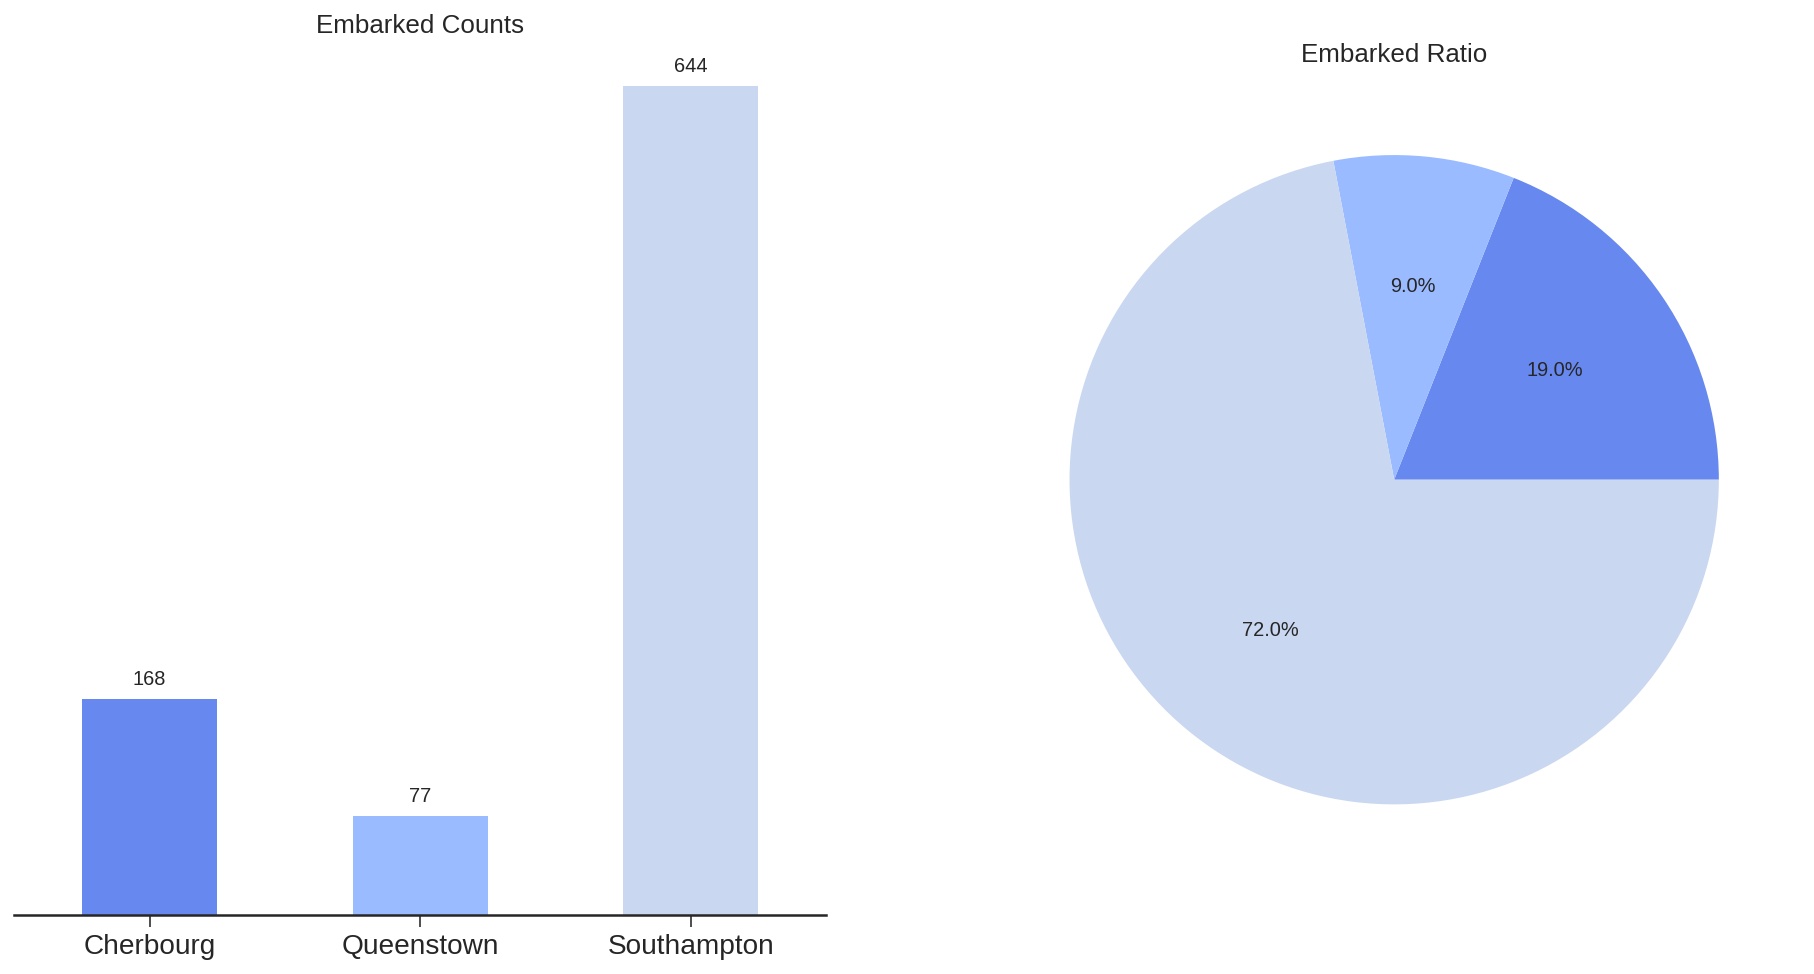

In [16]:
Groupby_OneCol_comp_plot(descript, 'Embarked')

In [17]:
def plot(table, legloc='upper right',
                                    plt_style = 'seaborn-ticks',
                                    color_palette="dark",sorter=None, stacked=False,
                                    kind = 'bar', percentage = True,
                               custom_title=None, minimal=True, figsize=(19,10), width=0.7 ):     
    grouped = table
    
    #Tranform to percentages
    if percentage == True:
        grouped = np.round(grouped.divide(grouped['Total'],axis=0)*100,0)
    try:   
        del grouped['Total']
    except:
        pass
    
    # rearrange the columns
    if sorter:
        grouped = grouped[sorter]

    plt.style.use(plt_style)
    sns.set_palette(sns.color_palette(color_palette))
    ax = grouped.plot(kind=kind,stacked=stacked, figsize=figsize, width=width)
    _ = plt.setp(ax.get_xticklabels(), rotation=0)  # Rotate labels
    plt.legend(loc=legloc) # plot the legend normally
    
    #annotate the bars
    if percentage == True:
      for p in ax.patches:
            ax.annotate('{}%'.format(int(np.round(p.get_height(),decimals=2))),
                                         (p.get_x()+p.get_width()/2.,
                                          p.get_height()), ha='center', va='center',
                                        xytext=(0, 10), textcoords='offset points')
    else:
      for p in ax.patches:
            ax.annotate(np.round(p.get_height(),decimals=2),
                                         (p.get_x()+p.get_width()/2.,
                                          p.get_height()), ha='center', va='center',
                                        xytext=(0, 10), textcoords='offset points')
    if minimal == True:
        ax.get_yaxis().set_ticks([])
        plt.xlabel('')
        sns.despine(top=True, right=True, left=True, bottom=False);
    else:
        pass     
    # set custom title    
    plt.title(custom_title)
    
def Groupby_TwoCol_Plot(df, col1, col2, legloc='upper right',
                                    plt_style = 'ggplot',
                                    color_palette="dark",sorter=None, stacked=False,
                                    kind = 'bar', percentage = True,
                               custom_title=None, minimal=True, figsize=(14,6), width=0.6):   
    
    #Group by Placement and Representative and unstack by Placement
    grouped = df.groupby([col2,col1]).size().unstack(col2)
    
    #Make a totals column sort and delete after
    grouped['Total'] = grouped.sum(axis=1)
    #grouped = grouped.sort_values('Total', ascending = False)
   
    plot(grouped, legloc=legloc,
                                    plt_style = plt_style,
                                    color_palette=color_palette,sorter=sorter, stacked=stacked,
                                    kind = kind , percentage = percentage,
                               custom_title=custom_title, minimal=minimal, figsize=figsize, width=width)

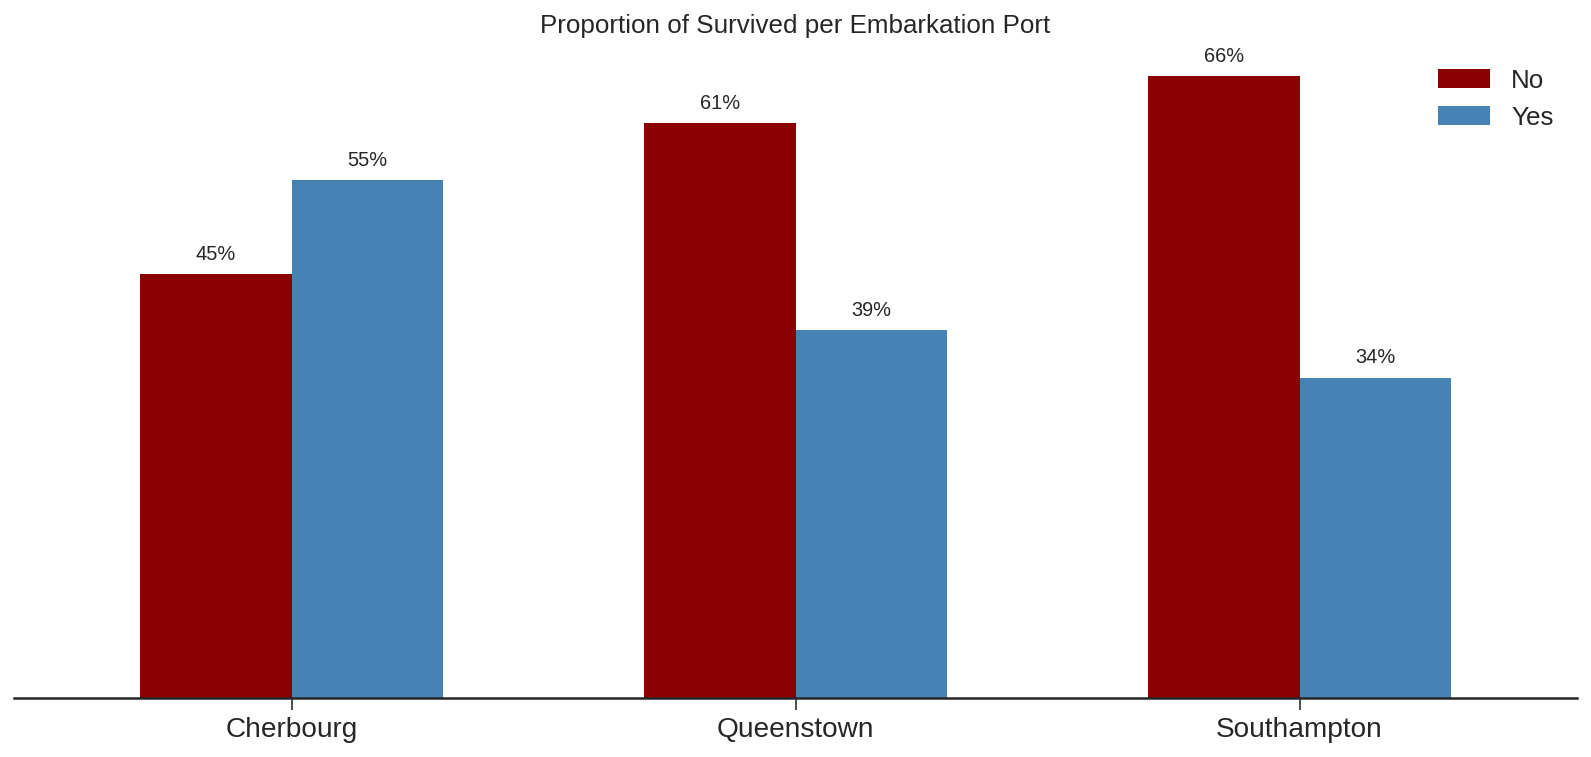

In [18]:
Groupby_TwoCol_Plot(descript,'Embarked', 'Survived', color_palette=('darkred','steelblue'),
                    plt_style = 'seaborn-ticks', custom_title='Proportion of Survived per Embarkation Port')

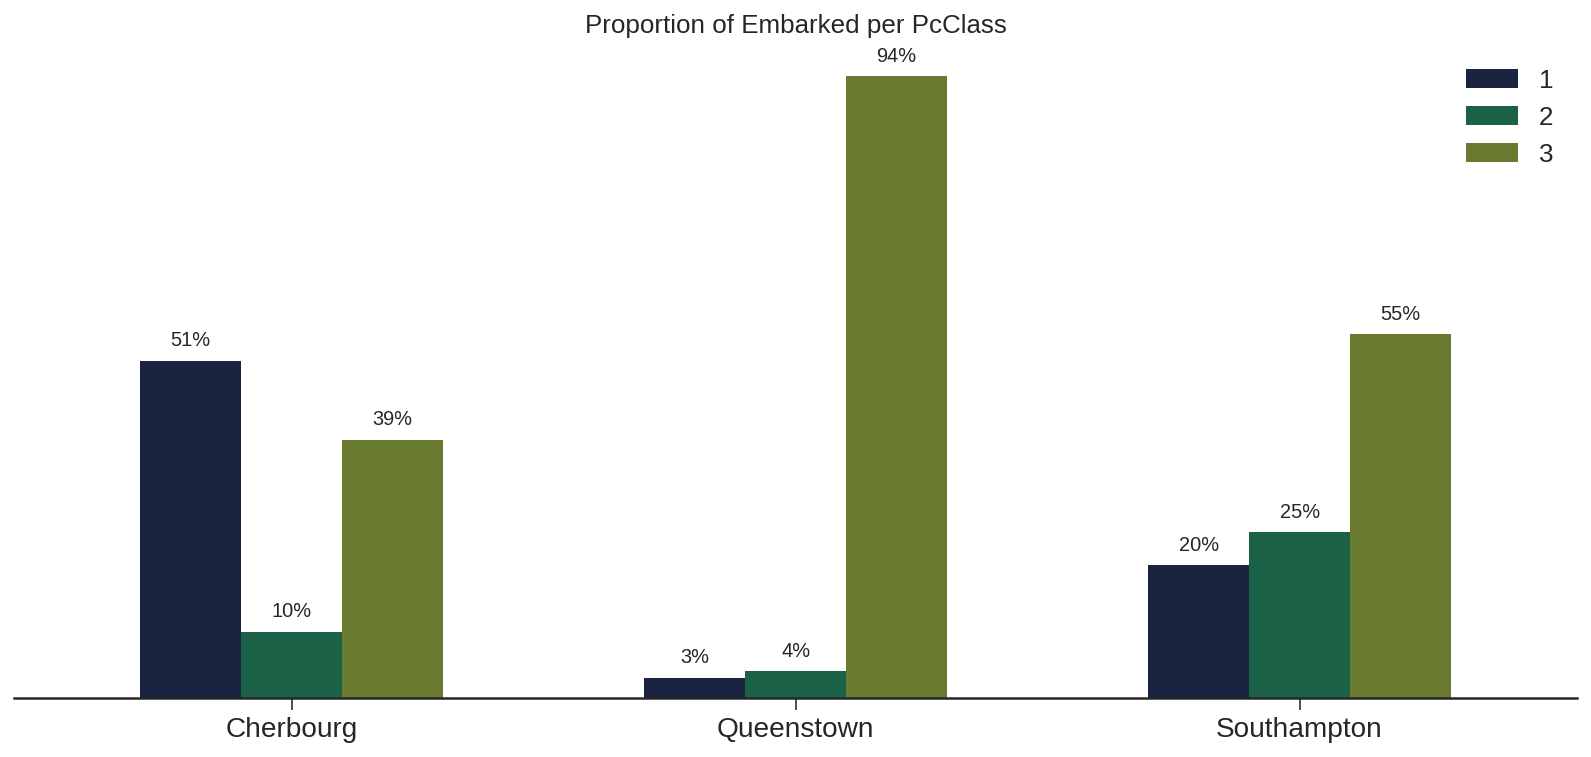

In [19]:
#Calculate percentages of port passengers per Class
Groupby_TwoCol_Plot(descript,'Embarked', 'Pclass', color_palette=('cubehelix'),
                    plt_style = 'seaborn-ticks', custom_title='Proportion of Embarked per PcClass', sorter = [1,2,3])

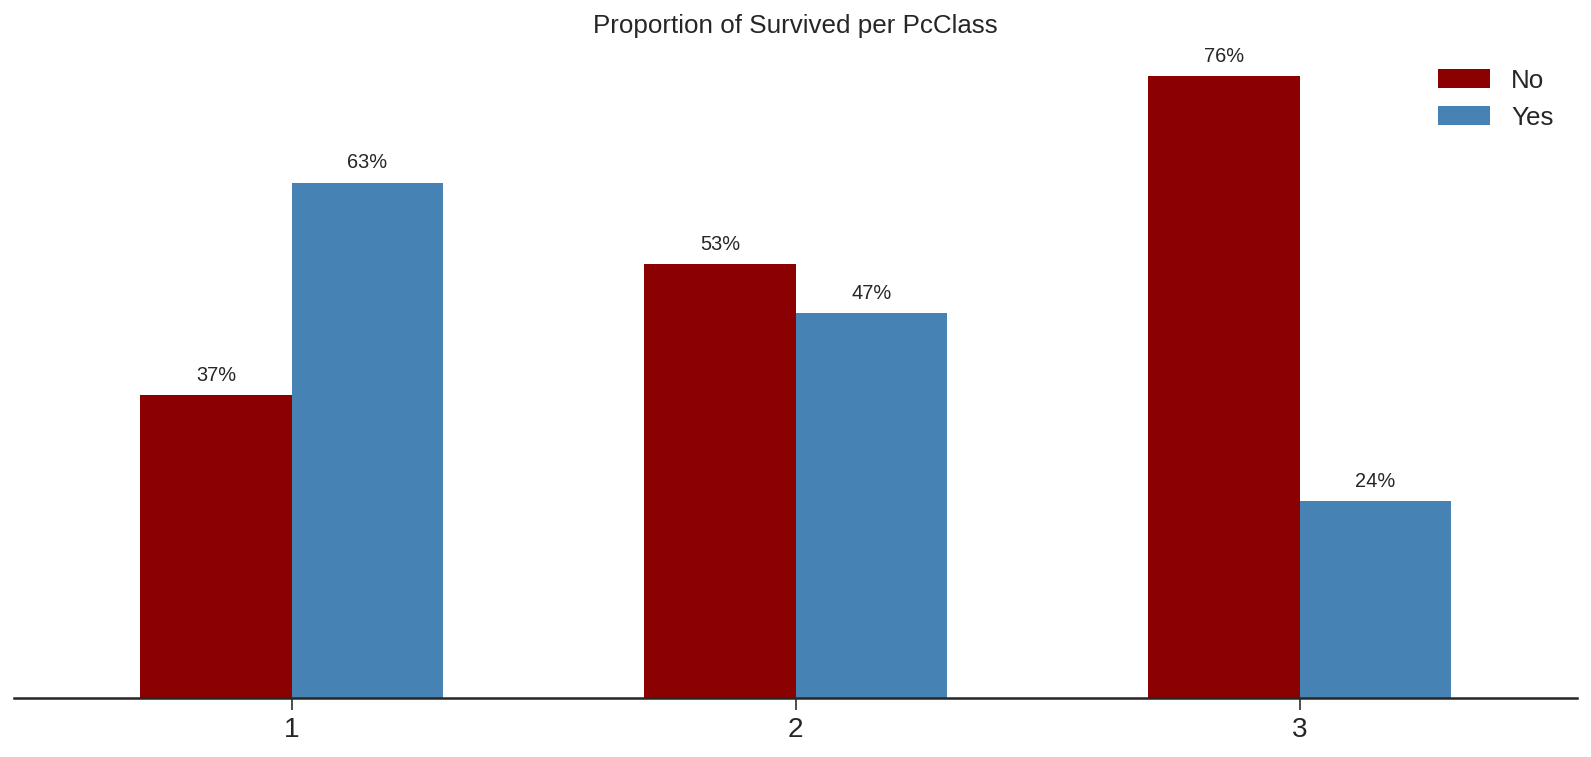

In [20]:
Groupby_TwoCol_Plot(descript,'Pclass', 'Survived', color_palette=('darkred','steelblue'),
                    plt_style = 'seaborn-ticks', custom_title='Proportion of Survived per PcClass')

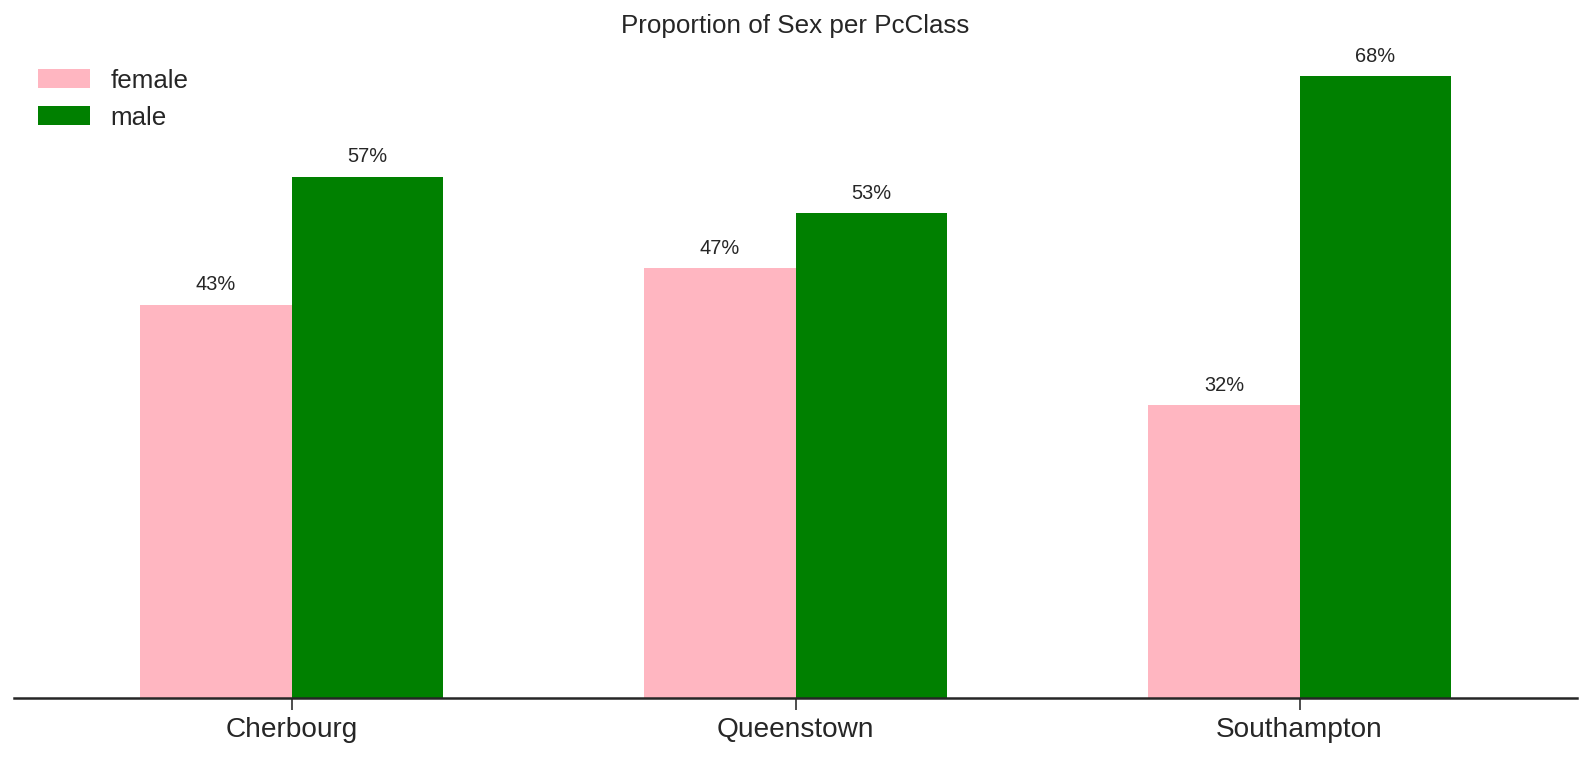

In [21]:
#Calculate percentages of port passengers per Sex
Groupby_TwoCol_Plot(descript,'Embarked', 'Sex', color_palette=('lightpink','green'),
                    plt_style = 'seaborn-ticks', custom_title='Proportion of Sex per PcClass',
                   legloc='upper left')

Total No. of Sex:891


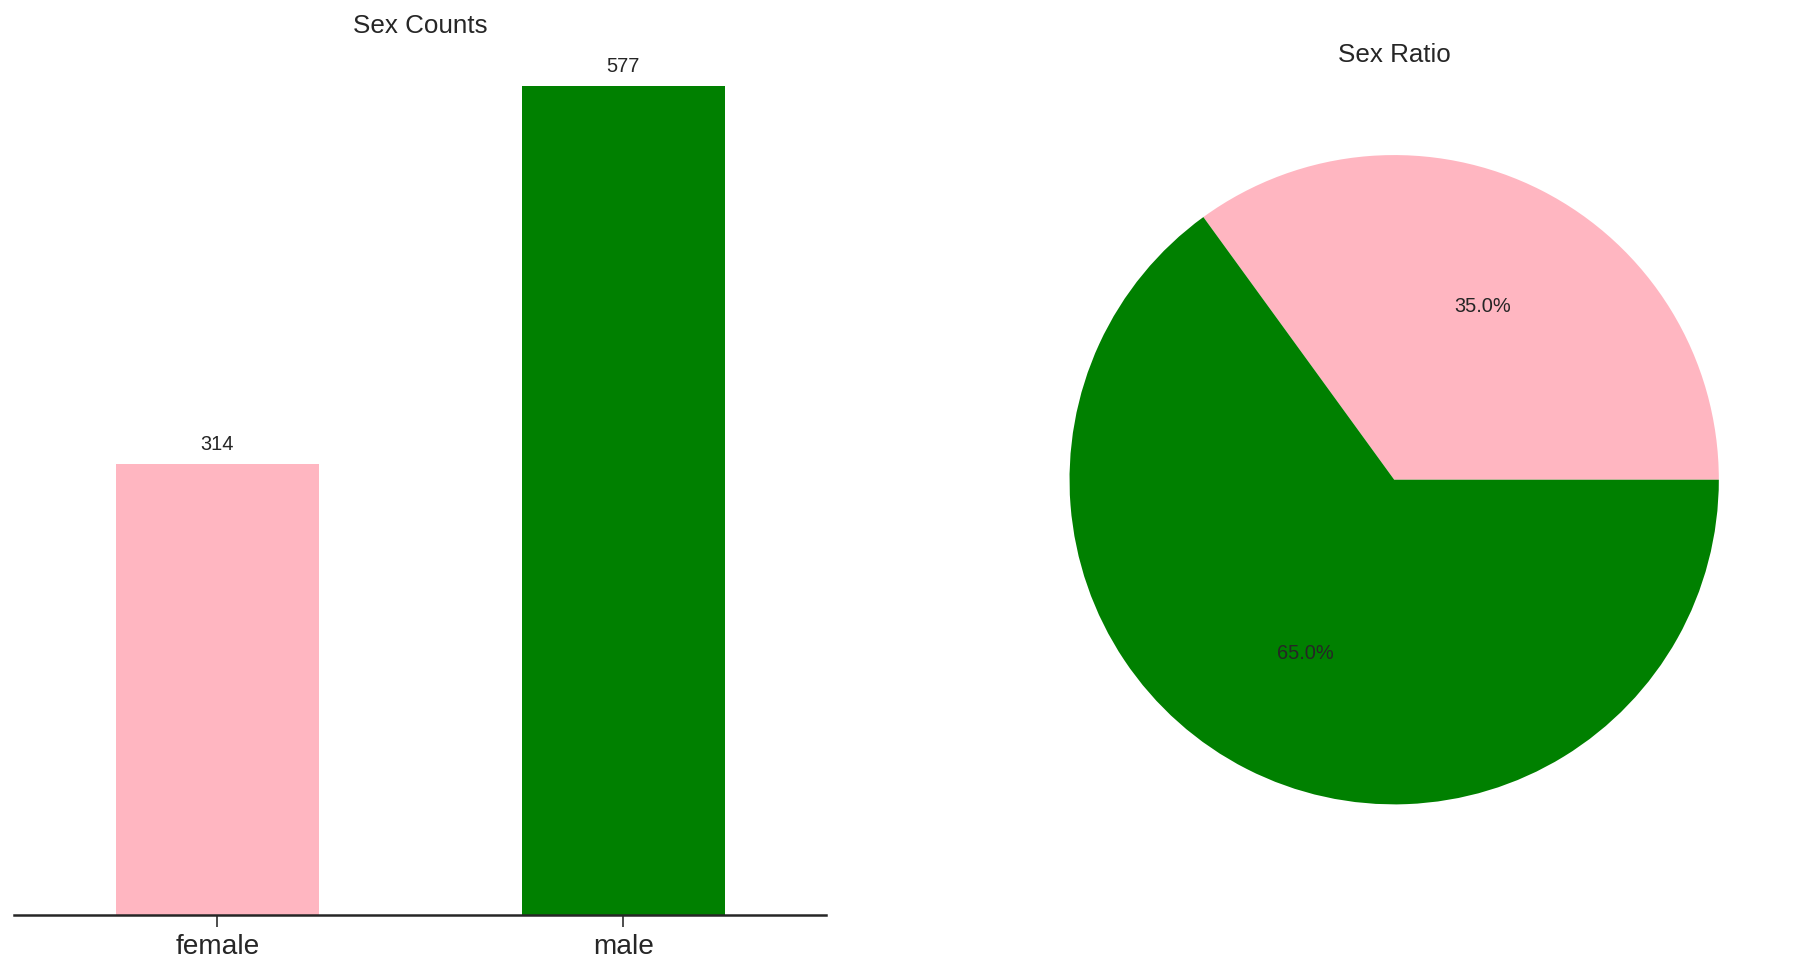

In [22]:
Groupby_OneCol_comp_plot(descript, 'Sex', color_palette = ('lightpink','green') )


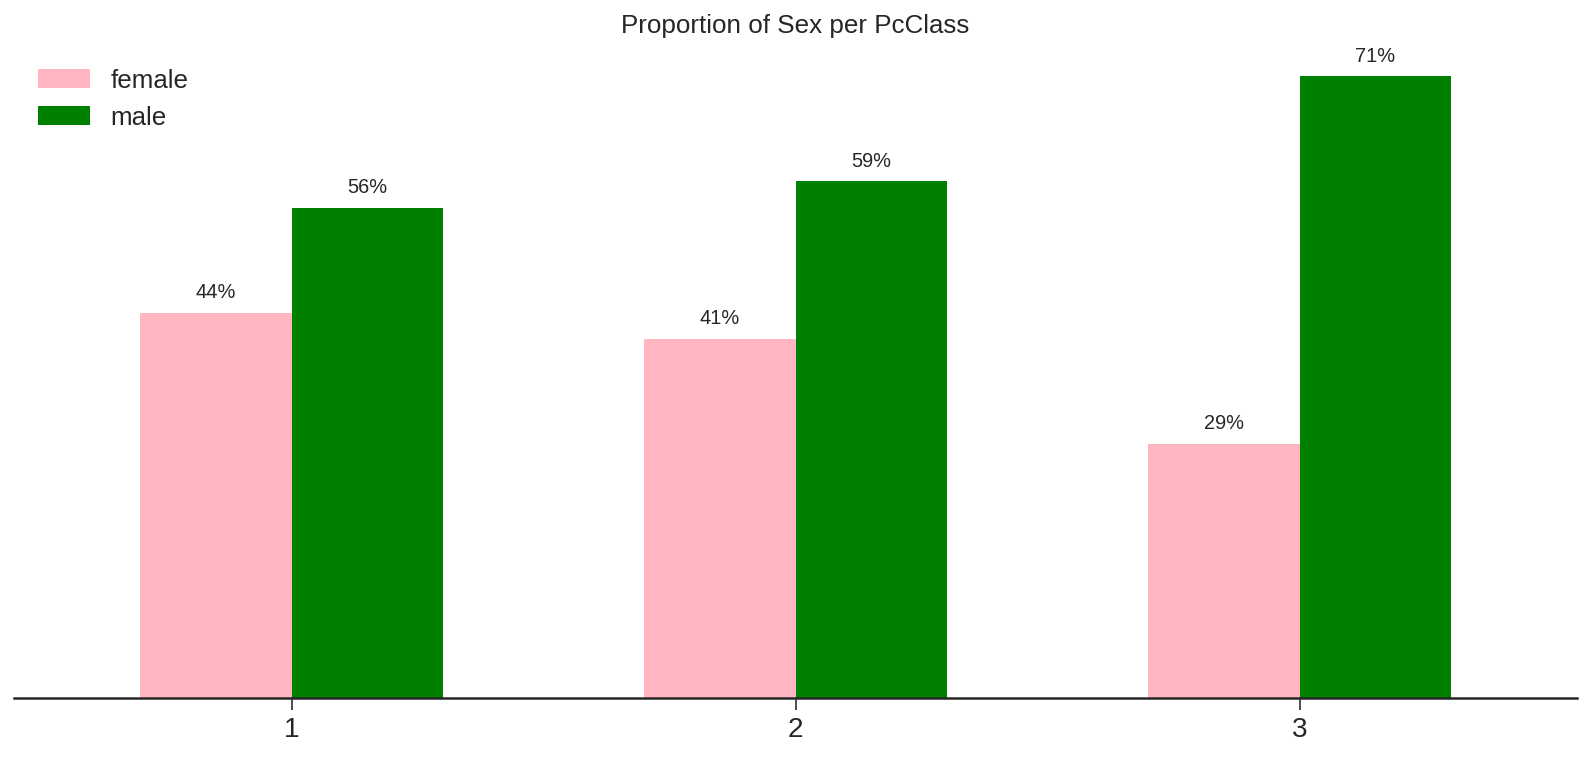

In [23]:
#Calculate percentages of Pclass per Sex
Groupby_TwoCol_Plot(descript,'Pclass', 'Sex', color_palette=('lightpink','green'),
                    plt_style = 'seaborn-ticks', custom_title='Proportion of Sex per PcClass',
                   legloc='upper left')


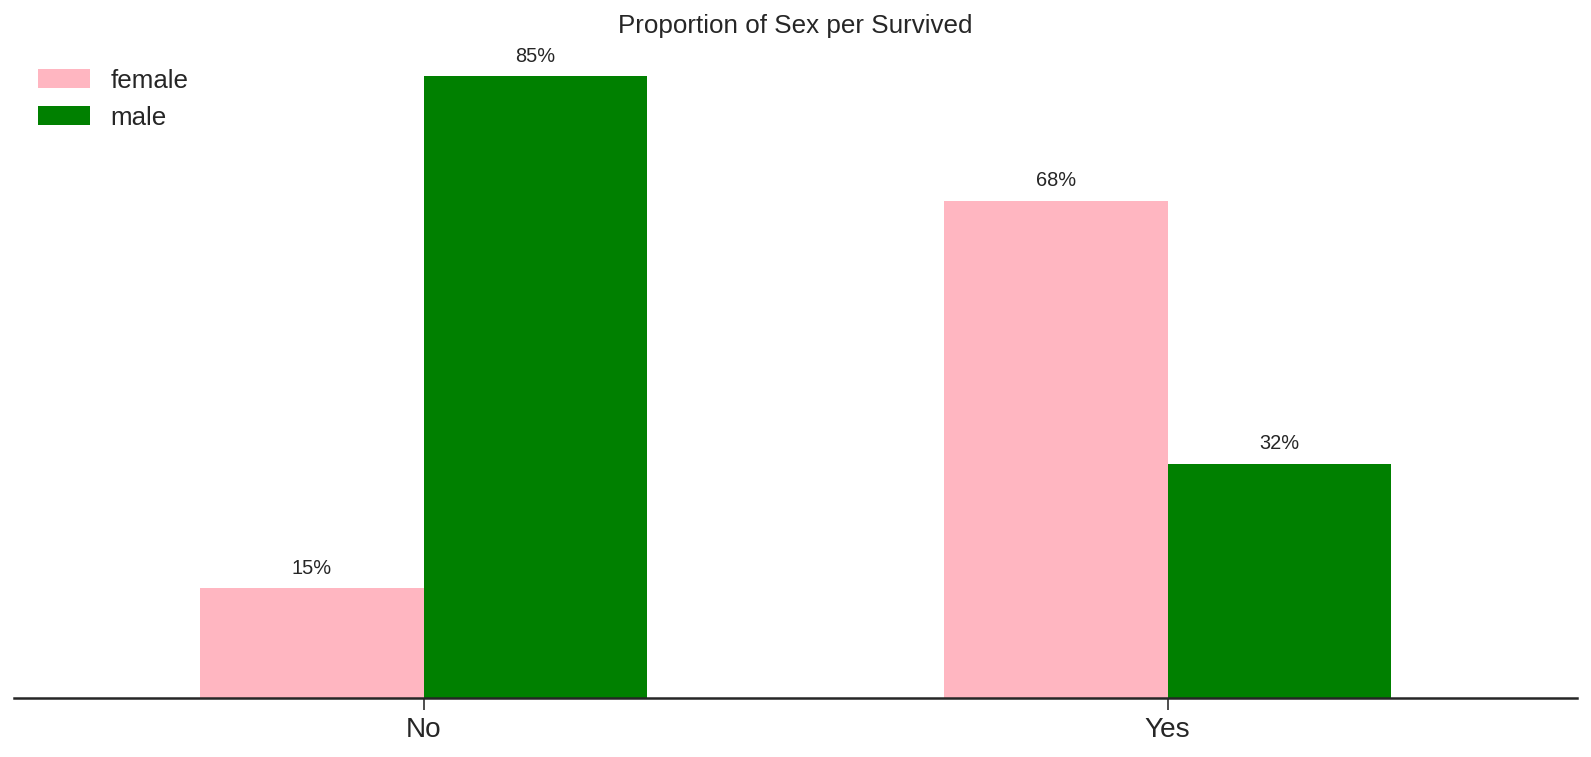

In [24]:
Groupby_TwoCol_Plot(descript,'Survived', 'Sex', color_palette=('lightpink','green'),
                    plt_style = 'seaborn-ticks', custom_title='Proportion of Sex per Survived',
                   legloc='upper left')


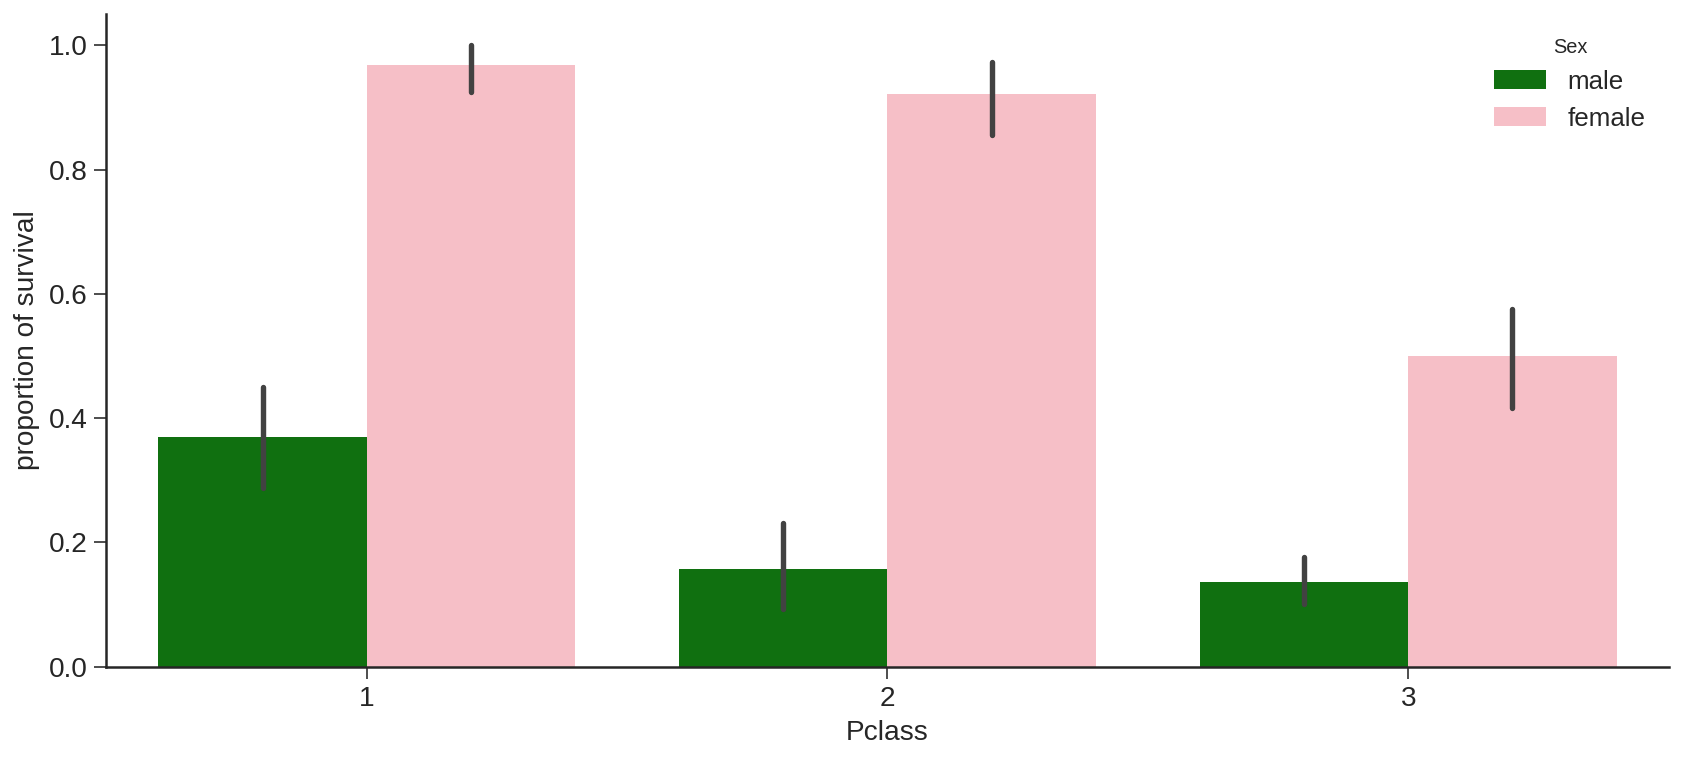

In [25]:
plt.figure(figsize=(14,6))
sns.set_palette(sns.color_palette(('green','lightpink')))
sns.barplot(data=n_titanic_data, x="Pclass", hue='Sex', y='Survived', estimator=np.mean);
plt.ylabel('proportion of survival')
sns.despine(top=True, right=True, left=False, bottom=False);

So We then conclude that : <br>
**1. The class effect the probability of survival** <br>
**2. Female more likely to survive than male** <br>
